# Predicting Tarmac Delays

This notebook aims to implement a linear regression model to predict tarmac delays. The data for this project includes weather data scraped from weather undeground and a list of flight statistics from the Bureau of Transportation. 


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [2]:
df = pd.read_pickle('FINAL2')

In [3]:
df.sample(10)

,Origin,Date,Carrier Code,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),...,Avg_Humidity,Min_Humid,Max_Wind,Avg_Wind,Min_Wind,Max_Pressure,Avg_Pressure,Min_Pressure,Num Gates,Cert_Date
126346,SFO,06/08/2018,AA,N186US,PHX,09:09,09:16,7.0,09:31,15.0,...,70.6,51,33,19.8,10,30.1,30.0,30.0,115,04/16/2002
65843,PHX,10/08/2018,UA,N24211,ORD,14:30,14:24,-6.0,14:38,14.0,...,57.8,34,16,7.3,0,28.6,28.6,28.5,116,07/26/1998
85853,STL,04/30/2018,WN,N429WN,DTW,08:30,08:29,-1.0,08:45,16.0,...,31.9,24,18,12.3,6,29.6,29.5,29.4,86,12/16/2002
114294,PHX,01/10/2018,WN,N267WN,SNA,21:55,22:28,33.0,22:37,9.0,...,77.6,52,9,5.8,0,28.9,28.8,28.6,116,02/25/2007
165784,JFK,06/29/2018,DL,N349NW,ATL,21:00,22:14,74.0,22:52,38.0,...,67.2,40,16,9.0,0,30.0,29.9,29.9,128,06/09/1993
146769,PHX,01/16/2018,WN,N707SA,IND,19:40,20:05,25.0,20:17,12.0,...,34.5,18,10,5.4,0,29.0,28.9,28.9,116,10/30/1998
82436,SFO,06/20/2018,DL,N877DN,MSP,00:50,00:53,3.0,01:06,13.0,...,70.2,58,28,16.6,8,30.0,30.0,30.0,115,04/25/2017
49552,PHX,10/29/2018,WN,N205WN,LAX,07:15,07:30,15.0,08:34,64.0,...,42.5,22,9,5.5,0,28.8,28.7,28.7,116,03/14/2005
15919,JFK,04/03/2018,AA,N112AN,LAX,17:00,17:19,19.0,18:06,47.0,...,91.9,79,14,8.9,0,30.2,30.1,29.9,128,03/18/2014
157293,STL,06/20/2018,WN,N8554X,LAX,21:35,23:35,120.0,23:41,6.0,...,81.7,52,29,7.8,0,29.3,29.3,29.2,86,12/06/2017


In [4]:
def get_daypart(time):
    
    start_times = ["05:00", "08:00", "12:00", "17:00", "21:00"]
    end_times = ["08:00", "12:00", "17:00", "21:00", "05:00"]
    day_part_list = ["Early Morning", "Morning", "Afternoon", "Evening", "Night"]
    
    for index, hour in enumerate(start_times):
        
        first_time = datetime.datetime.strptime(hour,"%H:%M")
        second_time = datetime.datetime.strptime(end_times[index],"%H:%M")
        
        if time.time() >= first_time.time() and time.time() < second_time.time():
            return day_part_list[index]
        
        elif index == 4:
            return day_part_list[index]

        
def get_day(date):
    
    num = date.to_pydatetime().weekday()
    day_dict = {0 : 'Mon', 1 : 'Tues', 2 : 'Wed', 3 : 'Thurs', 4 : 'Fri', 5 : 'Sat', 6 : 'Sun'}
    return day_dict[num]


def get_month(date):
    
    month_dict = {1 : 'Jan', 4 : 'Apr', 6 : 'Jun', 10 : 'Oct'}
    num = date.to_pydatetime().month
    return month_dict[num]



In [5]:
# Data Cleaning : This cell focuses on getting all the columns in the dataframe into the proper data types


df['Actual departure time'] = df['Actual departure time' ].str.replace('24', '00')

df = df[df['Cert_Date'] != 'Aircraft Description']
df = df[df['Cert_Date'] != 'None']

df['Scheduled departure time'] = df['Date'] + ' ' + df['Scheduled departure time'] 
df['Actual departure time'] = df['Date'] + ' ' + df['Actual departure time']

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

df['Scheduled departure time'] = pd.to_datetime(df['Scheduled departure time'], format="%m/%d/%Y %H:%M")
df['Actual departure time'] = pd.to_datetime(df['Actual departure time'], format="%m/%d/%Y %H:%M") 

df['Cert_Date'] = pd.to_datetime(df['Cert_Date'], format='%m/%d/%Y')

df['Age'] = (df['Date'] - df['Cert_Date']).dt.days

df['DayOfWeek'] = df['Date'].apply(lambda row: get_day(row))
df['Month'] = df['Date'].apply(lambda row: get_month(row))

df['DayPart'] = df['Actual departure time'].apply(lambda row: get_daypart(row))

In [6]:
df.dtypes

Origin                                              object
Date                                        datetime64[ns]
Carrier Code                                        object
Tail Number                                         object
Destination Airport                                 object
Scheduled departure time                    datetime64[ns]
Actual departure time                       datetime64[ns]
Departure delay (Minutes)                          float64
Wheels-off time                                     object
Taxi-Out time (Minutes)                            float64
Delay Carrier (Minutes)                            float64
Delay Weather (Minutes)                            float64
Delay National Aviation System (Minutes)           float64
Delay Security (Minutes)                           float64
Delay Late Aircraft Arrival (Minutes)              float64
Max_Temp                                            object
Avg_Temp                                            obje

# Exploratory Data Analysis

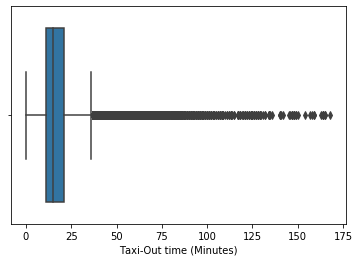

In [7]:
ax = sns.boxplot(x=df["Taxi-Out time (Minutes)"])
plt.show()

Taking a look at the boxplot reveals many outliers for the target variable (Taxi-Out time). Calculating the upper bound via the IQR results in an upper bound of 36. For the scope of this project, I've chosen to just set an upper bound to 30 mins and a lower bound of 5 mins. 

In [8]:
Q1 = df["Taxi-Out time (Minutes)"].quantile(0.25)
Q3 = df["Taxi-Out time (Minutes)"].quantile(0.75)
IQR = Q3 - Q1

bound = Q3 + 1.5 * IQR
print(bound)

36.0


## Months

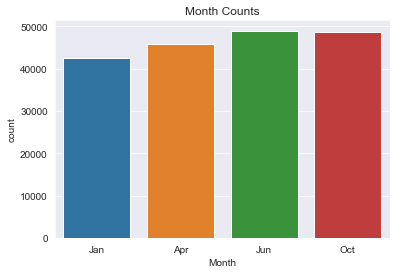

In [9]:
sns.set_style('darkgrid')
ax = sns.countplot(x="Month", data=df)
ax.set_title('Month Counts');

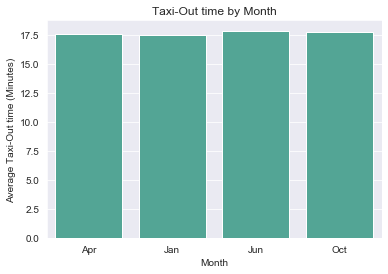

In [10]:
month_grouped = df.groupby(['Month'])['Taxi-Out time (Minutes)'].mean()

month_grouped = month_grouped.reset_index()

ax = sns.barplot(x='Month', y='Taxi-Out time (Minutes)', data=month_grouped, color='#45B39D');

ax.set_title('Taxi-Out time by Month');
ax.set_ylabel('Average Taxi-Out time (Minutes)');

## Days

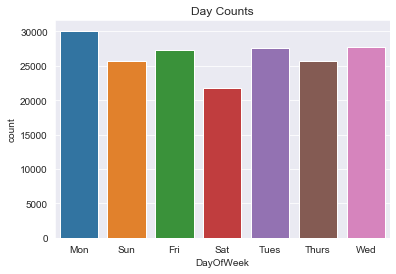

In [11]:
ax = sns.countplot(x="DayOfWeek", data=df)
ax.set_title('Day Counts');

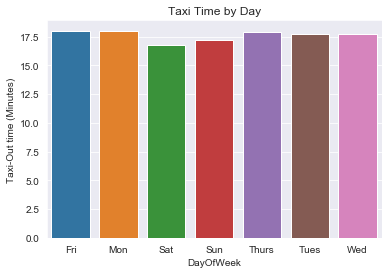

In [12]:
week_grouped = df.groupby(['DayOfWeek'])['Taxi-Out time (Minutes)'].mean()

week_grouped = week_grouped.reset_index()

ax = sns.barplot(x='DayOfWeek', y='Taxi-Out time (Minutes)', data=week_grouped);

ax.set_title('Taxi Time by Day');

## Time of Day

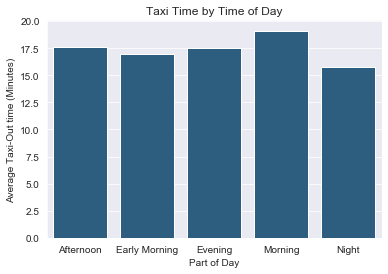

In [13]:
week_grouped = df.groupby(['DayPart'])['Taxi-Out time (Minutes)'].mean()

week_grouped = week_grouped.reset_index()

ax = sns.barplot(x='DayPart', y='Taxi-Out time (Minutes)', data=week_grouped, color='#1F618D')

ax.set_title('Taxi Time by Time of Day')
ax.set_xlabel('Part of Day')
ax.set_ylabel('Average Taxi-Out time (Minutes)');

## Airlines

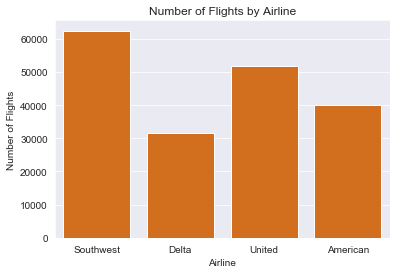

In [14]:
line_names = ['Southwest', 'Delta', 'United', 'American']
df['Carrier Code'].value_counts()
ax = sns.countplot(x="Carrier Code", data=df, color='#EF6C00')
ax.set_title('Number of Flights by Airline');
ax.set_xticklabels(line_names)
ax.set_xlabel('Airline')
ax.set_ylabel('Number of Flights');

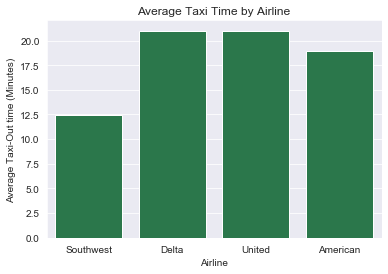

In [15]:
airline_grouped = df.groupby(['Carrier Code'])['Taxi-Out time (Minutes)'].mean()

airline_grouped = airline_grouped.reset_index()

orderl = ['WN', 'DL', 'UA', 'AA']
ax = sns.barplot(x='Carrier Code', y='Taxi-Out time (Minutes)', order=orderl, data=airline_grouped, color='#1E8449');
ax.set_xticklabels(line_names)
ax.set_xlabel('Airline')
ax.set_ylabel('Average Taxi-Out time (Minutes)')
ax.set_title('Average Taxi Time by Airline');

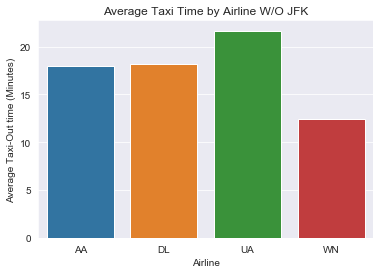

In [16]:
df2 = df.copy()
df2 = df2[(df2['Origin'] != 'JFK') & (df2['Origin'] != 'IAH') & (df2['Origin'] != 'HNL')]

airline_grouped = df2.groupby(['Carrier Code'])['Taxi-Out time (Minutes)'].mean()

airline_grouped = airline_grouped.reset_index() 

ax = sns.barplot(x='Carrier Code', y='Taxi-Out time (Minutes)', data=airline_grouped);
ax.set_ylabel('Average Taxi-Out time (Minutes)')
ax.set_xlabel('Airline')
ax.set_title('Average Taxi Time by Airline W/O JFK');

Notice that even if we remove the 3 airports that Southwest (WN) doesn't serve (JFK, IAH, HNL), Southwest still has noticeably shorter taxi times than the other 3 airlines.

## Airports

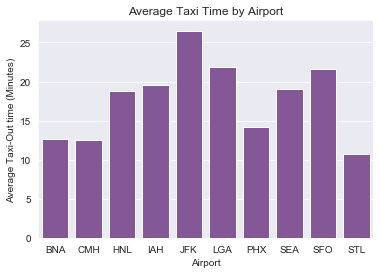

In [17]:
airport_grouped = df.groupby(['Origin'])['Taxi-Out time (Minutes)'].mean()
airport_grouped = airport_grouped.reset_index()
ax = sns.barplot(x='Origin', y='Taxi-Out time (Minutes)', data=airport_grouped, color='#884EA0')
ax.set_title('Average Taxi Time by Airport');
ax.set_ylabel('Average Taxi-Out time (Minutes)')
ax.set_xlabel('Airport');


Grouping by airport produces results as expected. Busier airports like JFK, LGA, and SFO tend to have more traffic and naturally higher taxi-out times.

# More Data Cleaning

In [18]:
df.columns

Index(['Origin', 'Date', 'Carrier Code', 'Tail Number', 'Destination Airport',
       'Scheduled departure time', 'Actual departure time',
       'Departure delay (Minutes)', 'Wheels-off time',
       'Taxi-Out time (Minutes)', 'Delay Carrier (Minutes)',
       'Delay Weather (Minutes)', 'Delay National Aviation System (Minutes)',
       'Delay Security (Minutes)', 'Delay Late Aircraft Arrival (Minutes)',
       'Max_Temp', 'Avg_Temp', 'Min_Temp', 'Max_Dew', 'Avg_DewPoint',
       'Min_Dew', 'Max_Humid', 'Avg_Humidity', 'Min_Humid', 'Max_Wind',
       'Avg_Wind', 'Min_Wind', 'Max_Pressure', 'Avg_Pressure', 'Min_Pressure',
       'Num Gates', 'Cert_Date', 'Age', 'DayOfWeek', 'Month', 'DayPart'],
      dtype='object')

In [19]:
df = pd.get_dummies(data=df, columns=['Origin', 'Carrier Code', 'DayPart' , 'DayOfWeek', 'Month'], drop_first=True)


In [20]:
# These are the selected columns that I will be using to model. All the columns were tested and 
# some were dropped based on high p-values or collinearity with other columns.

numeric_cols = ['Origin_CMH', 'Origin_HNL','Origin_IAH', 'Origin_JFK', 'Origin_LGA',
                'Origin_PHX', 'Origin_SEA', 'Origin_SFO', 'Origin_STL', 'Carrier Code_DL', 'Carrier Code_UA','Carrier Code_WN', 
                'DayPart_Early Morning', 'DayPart_Morning','DayPart_Evening', 'DayPart_Night', 'Departure delay (Minutes)', 'Taxi-Out time (Minutes)',
                'Delay Weather (Minutes)', 'Delay National Aviation System (Minutes)', 'Delay Carrier (Minutes)',
                'Avg_Temp', 'Avg_Wind']

In [21]:
only_num2 = df[numeric_cols].copy()
only_num2 = only_num2.apply(pd.to_numeric)
only_num2 = only_num2.dropna(how='any')
only_num2 = only_num2[only_num2['Departure delay (Minutes)'] <= 60] 
only_num2 = only_num2[only_num2['Taxi-Out time (Minutes)'] >= 5] 
only_num2 = only_num2[only_num2['Taxi-Out time (Minutes)'] <= 30]

only_num2 = only_num2[only_num2['Delay Weather (Minutes)'] < 30]
only_num2 = only_num2[only_num2['Delay Carrier (Minutes)'] < 30]
only_num2 = only_num2[only_num2['Delay National Aviation System (Minutes)'] < 30]
#only_num2 = only_num2[only_num2['Avg_Pressure'] <= 30.4]

only_num2['Departure delay (Minutes)'] = only_num2['Departure delay (Minutes)'].astype(int)
only_num2['Taxi-Out time (Minutes)'] = only_num2['Taxi-Out time (Minutes)'].astype(int)                  
only_num2['Delay Weather (Minutes)'] = only_num2['Delay Weather (Minutes)'].astype(int)                     
only_num2['Delay National Aviation System (Minutes)'] = only_num2['Delay National Aviation System (Minutes)'].astype(int)    
only_num2['Delay Carrier (Minutes)'] = only_num2['Delay Carrier (Minutes)'].astype(int)                                        


In [22]:
only_num2.dtypes

Origin_CMH                                    uint8
Origin_HNL                                    uint8
Origin_IAH                                    uint8
Origin_JFK                                    uint8
Origin_LGA                                    uint8
Origin_PHX                                    uint8
Origin_SEA                                    uint8
Origin_SFO                                    uint8
Origin_STL                                    uint8
Carrier Code_DL                               uint8
Carrier Code_UA                               uint8
Carrier Code_WN                               uint8
DayPart_Early Morning                         uint8
DayPart_Morning                               uint8
DayPart_Evening                               uint8
DayPart_Night                                 uint8
Departure delay (Minutes)                     int64
Taxi-Out time (Minutes)                       int64
Delay Weather (Minutes)                       int64
Delay Nation

In [23]:
only_num2.describe() 

,Origin_CMH,Origin_HNL,Origin_IAH,Origin_JFK,Origin_LGA,Origin_PHX,Origin_SEA,Origin_SFO,Origin_STL,Carrier Code_DL,...,DayPart_Morning,DayPart_Evening,DayPart_Night,Departure delay (Minutes),Taxi-Out time (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Carrier (Minutes),Avg_Temp,Avg_Wind
count,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,...,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.000000,157546.00000,157546.000000,157546.000000,157546.000000
mean,0.033552,0.021784,0.126725,0.066457,0.030537,0.251882,0.102002,0.173752,0.097375,0.161553,...,0.257969,0.200830,0.099438,1.916900,15.494199,0.026627,0.53811,0.605645,63.313647,8.536796
std,0.180074,0.145978,0.332666,0.249080,0.172060,0.434095,0.302652,0.378898,0.296468,0.368041,...,0.437518,0.400623,0.299250,11.810659,5.818069,0.727743,3.02511,3.164874,16.491188,3.602446
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-22.000000,5.000000,0.000000,0.00000,0.000000,1.400000,1.400000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-5.000000,11.000000,0.000000,0.00000,0.000000,53.300000,5.800000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-2.000000,15.000000,0.000000,0.00000,0.000000,62.100000,8.100000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,4.000000,19.000000,0.000000,0.00000,0.000000,75.900000,10.600000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,60.000000,30.000000,29.000000,29.00000,29.000000,99.900000,25.100000


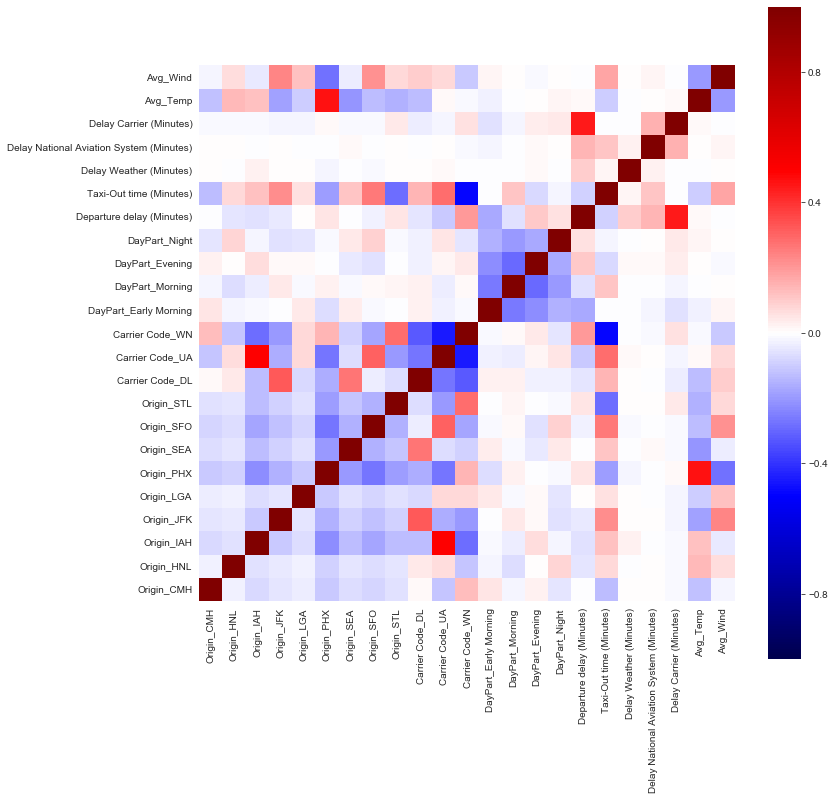

In [24]:
fig, ax = plt.subplots(figsize=(12,12)) 

sns.heatmap(only_num2.corr(), cmap="seismic", vmin=-1, vmax=1, square=True);

plt.ylim([0,23]);

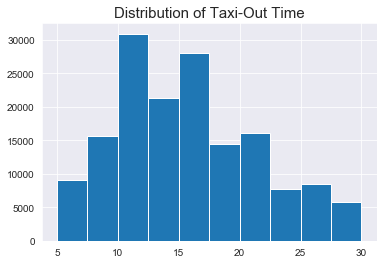

In [25]:
X2 = only_num2.copy()
X2 = X2.drop(columns=['Taxi-Out time (Minutes)']) 
y2 = only_num2['Taxi-Out time (Minutes)']
y2.hist(); 
plt.title('Distribution of Taxi-Out Time', size=15);

Notice that the target variable doesn't exactly follow a normal distribution. While it may not be necessary for the target variable to have a perfectly normal distribution, using a natural logged version of the target resulted in a better model.

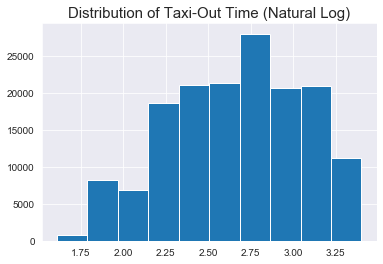

In [26]:
y2 = np.log(y2)
y2.hist();
plt.title('Distribution of Taxi-Out Time (Natural Log)', size=15);

# Statsmodels Linear Regression

In [27]:
std = StandardScaler() 
std.fit(X2.values) 
X2_scaled = std.transform(X2.values)
model2 = sm.OLS(y2, sm.add_constant(X2_scaled))

fit2 = model2.fit()
fit2.summary() 


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Taxi-Out time (Minutes)   R-squared:                       0.446
Model:                                 OLS   Adj. R-squared:                  0.446
Method:                      Least Squares   F-statistic:                     5765.
Date:                     Mon, 14 Oct 2019   Prob (F-statistic):               0.00
Time:                             13:34:58   Log-Likelihood:                -28553.
No. Observations:                   157546   AIC:                         5.715e+04
Df Residuals:                       157523   BIC:                         5.738e+04
Df Model:                               22                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6674      0.001   3649.961      0.000       2.666       2.669
x1            -0.0087      0.001    -10.381      0.000      -0.010      -0.007
x2             0.0466      0.001     54.593      0.000       0.045       0.048
x3             0.0677      0.001     54.330      0.000       0.065       0.070
x4             0.0869      0.001     83.904      0.000       0.085       0.089
x5             0.0565      0.001     65.872      0.000       0.055       0.058
x6             0.0232      0.001     17.901      0.000       0.021       0.026
x7             0.0806      0.001     76.483      0.000       0.079       0.083
x8             0.1207      0.001     95.661      0.000       0.118       0.123
x9            -0.0364      0.001    -36.263      0.000      -0.038      -0.034
x10           -0.0330      0.001    -34.646      0.000      -0.035      -0.031
x11           -0.0190      0.001    -16.487      0.000      -0.021      -0.017
x12           -0.1555      0.001   -148.738      0.000      -0.158      -0.153
x13            0.0131      0.001     15.234      0.000       0.011       0.015
x14            0.0457      0.001     51.804      0.000       0.044       0.047
x15           -0.0079      0.001     -9.134      0.000      -0.010      -0.006
x16           -0.0142      0.001    -17.375      0.000      -0.016      -0.013
x17           -0.0053      0.001     -6.213      0.000      -0.007      -0.004
x18            0.0064      0.001      8.655      0.000       0.005       0.008
x19            0.0359      0.001     48.335      0.000       0.034       0.037
x20            0.0084      0.001     10.128      0.000       0.007       0.010
x21           -0.0174      0.001    -19.544      0.000      -0.019      -0.016
x22            0.0089      0.001     10.884      0.000       0.007       0.010
==============================================================================
Omnibus:                      641.256   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              643.690
Skew:                           0.151   Prob(JB):                    1.68e-140
Kurtosis:                       2.915   Cond. No.                         4.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

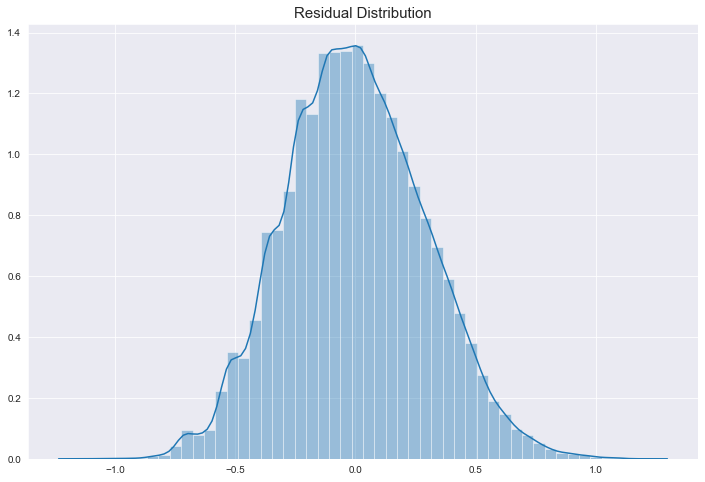

In [28]:
plt.figure(figsize=(12,8))
sns.distplot(fit2.resid)
plt.title('Residual Distribution', size=15);

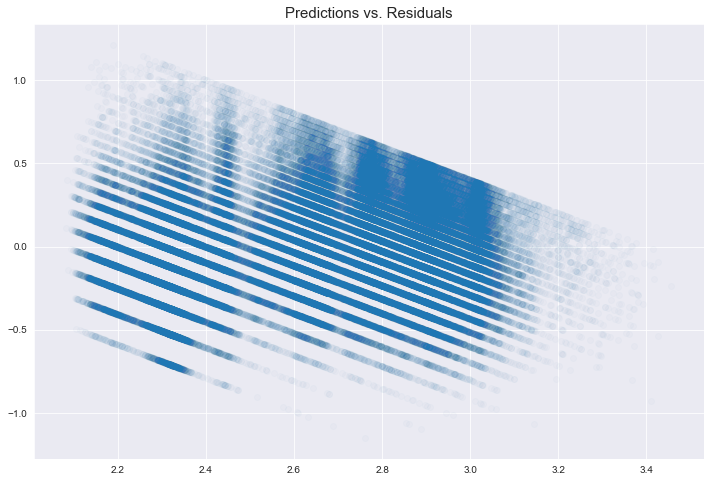

In [29]:
plt.figure(figsize=(12,8))
plt.scatter(fit2.predict(), fit2.resid, alpha = 0.02);
plt.title('Predictions vs. Residuals', size=15);

**Note:** This model obviously displays heteroscedasticity and to some extent this is expected given the nature of this problem. The **Delay(NAS)** is relatively sparse, but likely a very important feature in predicting longer delays which may help explain why the model tends to predict longer delays better than shorter ones.

## Scikit-Learn Regression and Validation

In [30]:
X, X_test, y, y_test = train_test_split(X2, y2, test_size=.2, random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [32]:
lm = LinearRegression() 

lm.fit(X_train, y_train)

print(f'Linear Regression train R^2: {lm.score(X_train, y_train):.3f}')
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

#Need to scale features for Ridge Regression
scaler = StandardScaler() 

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_train_scaled, y_train)

print(' ')
print(f'Ridge Regression train R^2: {lm_reg.score(X_train_scaled, y_train):.3f}')
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')


Linear Regression train R^2: 0.446
Linear Regression val R^2: 0.445
 
Ridge Regression train R^2: 0.446
Ridge Regression val R^2: 0.445


In [33]:
coef_list = list(zip(X_train.columns, np.exp(lm.coef_)))
coef_list = sorted(coef_list, key=lambda x: x[1])
coef_list

[('Carrier Code_WN', 0.7222683568393444),
 ('Origin_STL', 0.8877542960766797),
 ('Carrier Code_DL', 0.9118615914909249),
 ('DayPart_Night', 0.9483575839091576),
 ('Origin_CMH', 0.950860905972712),
 ('Carrier Code_UA', 0.9613949113799728),
 ('DayPart_Evening', 0.9802540550625779),
 ('Avg_Temp', 0.9989599229076832),
 ('Departure delay (Minutes)', 0.9995831376271812),
 ('Avg_Wind', 1.0025324497092243),
 ('Delay Carrier (Minutes)', 1.0025433358336362),
 ('Delay Weather (Minutes)', 1.0075497099206243),
 ('Delay National Aviation System (Minutes)', 1.011528487264963),
 ('DayPart_Early Morning', 1.0346841791546992),
 ('Origin_PHX', 1.0545622436281048),
 ('DayPart_Morning', 1.107711977533887),
 ('Origin_IAH', 1.222159062486494),
 ('Origin_SEA', 1.3095588241919927),
 ('Origin_SFO', 1.3728572320188412),
 ('Origin_HNL', 1.3773564028656733),
 ('Origin_LGA', 1.3817095695544606),
 ('Origin_JFK', 1.420092363769285)]

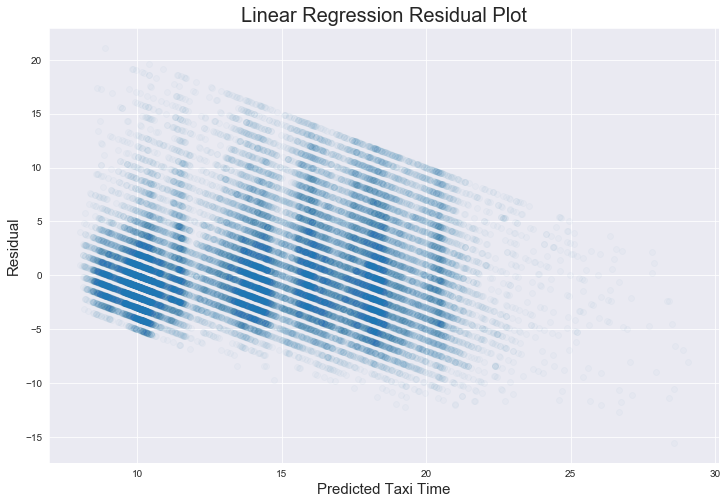

In [34]:
y_val_pred= lm.predict(X_val)

plt.figure(figsize=(12,8))
plt.scatter(np.exp(y_val_pred), np.exp(y_val) - np.exp(y_val_pred), alpha = 0.025)
plt.title('Linear Regression Residual Plot', size = 20)
plt.xlabel('Predicted Taxi Time', size = 15);
plt.ylabel('Residual', size = 15);
plt.savefig('residual_plot', bbox_inches ='tight', dpi = 400)

#plt.scatter(np.exp(y_test_pred), np.exp(y_test), alpha = 0.1)

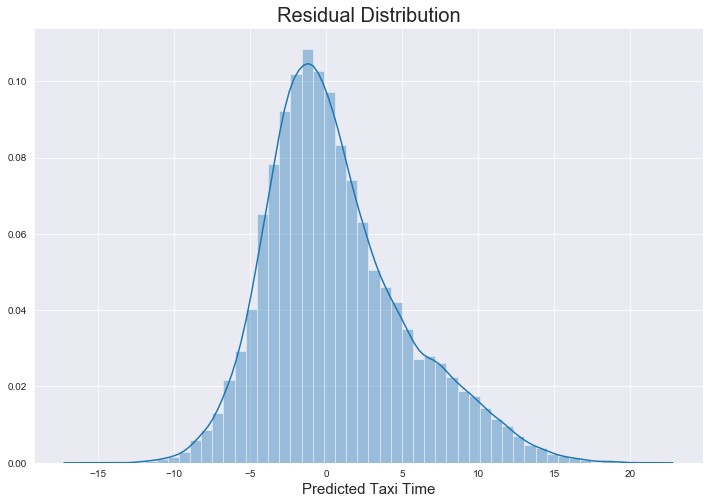

In [35]:
plt.figure(figsize=(12,8))
sns.distplot(np.exp(y_val) - np.exp(y_val_pred)) 
plt.title('Residual Distribution', size = 20)
plt.xlabel('Predicted Taxi Time', size = 15);

# Ridge Regression Plot

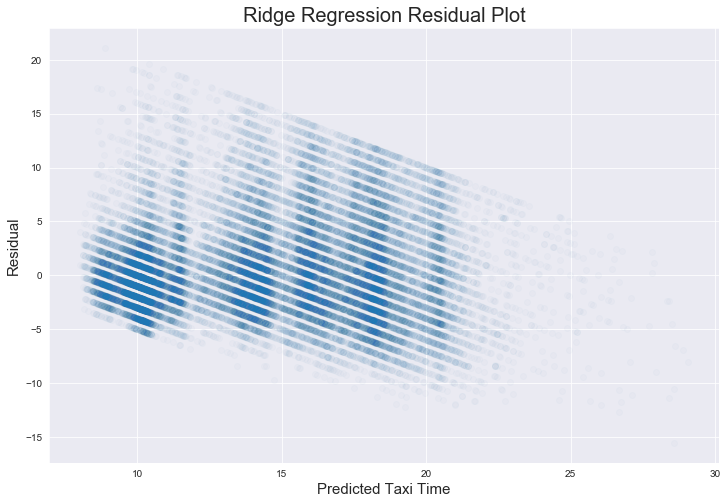

In [44]:
y_reg_val_pred = lm_reg.predict(X_val_scaled)

plt.figure(figsize=(12,8))
plt.scatter(np.exp(y_reg_val_pred), np.exp(y_val) - np.exp(y_reg_val_pred), alpha = 0.02);
plt.title('Ridge Regression Residual Plot', size = 20)
plt.xlabel('Predicted Taxi Time', size = 15);
plt.ylabel('Residual', size = 15);



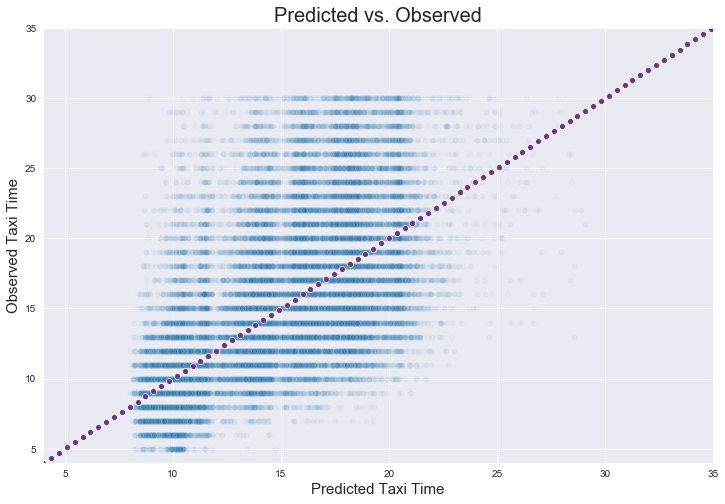

In [45]:

plt.figure(figsize = (12,8))
ax = sns.scatterplot(np.exp(y_val_pred), np.exp(y_val), alpha = 0.05)
ax = sns.scatterplot(np.linspace(4,40,100), np.linspace(4,40,100), color='#6C3483')
plt.title('Predicted vs. Observed', size=20)
plt.xlabel('Predicted Taxi Time', size=15)
plt.ylabel('Observed Taxi Time', size=15)
plt.ylim([4,35]);
plt.xlim([4,35]);

plt.savefig('comparison', bbox_inches ='tight', dpi = 400)

# Mean Absolute Error

In [40]:
mae_linear = np.mean(np.abs(np.exp(y_val) - np.exp(y_val_pred)))
print("Linear MAE on Validation:", mae_linear)

y_test_pred= lm.predict(X_test)
mae_linear_test = np.mean(np.abs(np.exp(y_test) - np.exp(y_test_pred)))
print("Linear MAE on Test:", mae_linear_test)

Linear MAE on Validation: 3.553145932561853
Linear MAE on Test: 3.555278683863826


In [63]:
mae_justridge = np.mean(np.abs(np.exp(y_reg_val_pred) - np.exp(y_val))) 

y_reg_test_pred= lm_reg.predict(X_test_scaled)
mae_justridge_test = np.mean(np.abs(np.exp(y_reg_test_pred) - np.exp(y_test))) 

print("Ridge MAE on Validation:", mae_justridge)
print("Ridge MAE on Test:", mae_justridge_test)

Ridge MAE on Validation: 3.553146054210937
Ridge MAE on Test: 3.5552786056100945


# Cross Validation

In [49]:
kf = KFold(n_splits=5, shuffle=True, random_state = 89)

X_scaled = scaler.fit_transform(X.values)

print("R^2 Linear:",np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print("R^2 Ridge:",np.mean(cross_val_score(lm_reg, X_scaled, y, cv=kf, scoring='r2')))


R^2 Linear: 0.44571214061031117
R^2 Ridge: 0.4457121438847823


# Polynomial Transformation

In [50]:
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

X_poly = poly.transform(X.values)

X_poly_scaled = scaler.fit_transform(X_poly)

lm_poly = LinearRegression()

lm_poly.fit(X_train_poly, y_train)


print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

print(' ')

print("R^2 Poly Linear:",np.mean(cross_val_score(LinearRegression(), X_poly, y, cv=kf, scoring='r2')))
print("MAE Poly Linear:",np.mean(cross_val_score(LinearRegression(), X_poly, y, cv=kf, scoring='neg_mean_absolute_error')))

print("R^2 Poly Ridge:",np.mean(cross_val_score(Ridge(alpha=1), X_poly_scaled, y, cv=kf, scoring='r2')))
print("MAE Poly Ridge:",np.mean(cross_val_score(Ridge(alpha=1), X_poly_scaled, y, cv=kf, scoring='neg_mean_absolute_error')))

Degree 2 polynomial regression val R^2: 0.496
 
R^2 Poly Linear: 0.4988160172427046
MAE Poly Linear: -0.22131909317355564
R^2 Poly Ridge: 0.49881633677097614
MAE Poly Ridge: -0.22131914201468383


In [70]:
y_poly_predict = lm_poly.predict(X_val_poly)

mae_poly = np.mean(np.abs(np.exp(y_poly_predict) - np.exp(y_val))) 

print('MAE Val for RidgeCV:', mae_poly)


MAE Val for RidgeCV: 3.3906636365468645


**Note:** MAE values using cross_val_score are comparing natural log transformed values of the target variable

# RidgeCV

In [65]:
alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=kf)

ridge_model.fit(X_train_scaled, y_train)

print('RidgeCV alpha:', ridge_model.alpha_)

print(f'RidgeCV train R^2: {ridge_model.score(X_train_scaled, y_train):.3f}')
print(f'RidgeCV val R^2: {ridge_model.score(X_val_scaled, y_val):.3f}')


RidgeCV alpha: 12.458833642950081
RidgeCV train R^2: 0.446
RidgeCV val R^2: 0.445


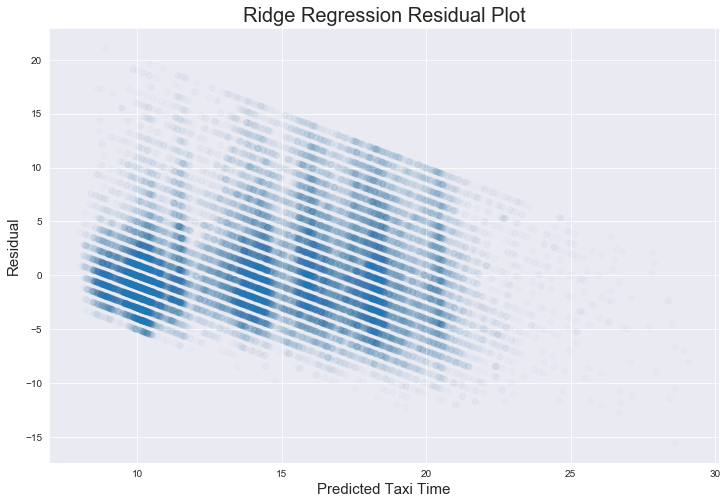

In [52]:
y_rcv_val_pred = ridge_model.predict(X_val_scaled)

plt.figure(figsize=(12,8))
plt.scatter(np.exp(y_rcv_val_pred), np.exp(y_val) - np.exp(y_rcv_val_pred), alpha = 0.02)
plt.title('Ridge Regression Residual Plot', size = 20)
plt.xlabel('Predicted Taxi Time', size = 15);
plt.ylabel('Residual', size = 15);


In [68]:
mae_rcv = np.mean(np.abs(np.exp(y_rcv_val_pred) - np.exp(y_val))) 

print('MAE Val for RidgeCV:', mae_rcv)


y_rcv_test_pred = ridge_model.predict(X_test_scaled)

mae_rcv_test = np.mean(np.abs(np.exp(y_rcv_test_pred) - np.exp(y_test))) 

print('MAE Test for RidgeCV:', mae_rcv_test)

MAE Val for RidgeCV: 3.3909457826457534
MAE Test for RidgeCV: 3.555277817437563


# LassoCV

In [54]:
alphavec = 10**np.linspace(-3,3,200)

lasso_model = LassoCV(alphas = alphavec, cv=kf)

lasso_model.fit(X_train_scaled, y_train)

print('LassoCV alpha:', lasso_model.alpha_)

print(f'LassoCV train R^2: {lasso_model.score(X_train_scaled, y_train):.3f}')
print(f'LassoCV val R^2: {lasso_model.score(X_val_scaled, y_val):.3f}')


LassoCV alpha: 0.001
LassoCV train R^2: 0.446
LassoCV val R^2: 0.444


In [55]:
y_lcv_val_pred = lasso_model.predict(X_val_scaled)

mae_lcv = np.mean(np.abs(np.exp(y_lcv_val_pred) - np.exp(y_val))) 

print('MAE for LassoCV:', mae_lcv)

MAE for LassoCV: 3.5547510358587258


# RidgeCV for Polynomial Features

In [57]:
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)

X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_val_poly_scaled = scaler.fit_transform(X_val_poly)


alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=kf)

ridge_model.fit(X_train_poly_scaled, y_train)

print('RidgeCV alpha:', ridge_model.alpha_)

print(f'RidgeCV train R^2: {ridge_model.score(X_train_poly_scaled, y_train):.3f}')
print(f'RidgeCV val R^2: {ridge_model.score(X_val_poly_scaled, y_val):.3f}')

RidgeCV alpha: 83.09941949353396
RidgeCV train R^2: 0.502
RidgeCV val R^2: 0.496


In [58]:
y_rcv_val_pred = ridge_model.predict(X_val_poly_scaled)

mae_rcv = np.mean(np.abs(np.exp(y_rcv_val_pred) - np.exp(y_val))) 

print('MAE Poly for RidgeCV:', mae_rcv)

MAE Poly for RidgeCV: 3.3909457826457534


# LassoCV for Polynomial Features

In [60]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=kf)

lasso_model.fit(X_train_poly_scaled, y_train)

print('LassoCV alpha:', lasso_model.alpha_)

print(f'LassoCV train R^2: {lasso_model.score(X_train_poly_scaled, y_train):.3f}')
print(f'LassoCV val R^2: {lasso_model.score(X_val_poly_scaled, y_val):.3f}')

LassoCV alpha: 0.01
LassoCV train R^2: 0.469
LassoCV val R^2: 0.465


In [61]:
y_lcv_val_pred = lasso_model.predict(X_val_poly_scaled)

mae_lcv = np.mean(np.abs(np.exp(y_lcv_val_pred) - np.exp(y_val))) 

print('MAE Poly for LassoCV:', mae_lcv)

MAE Poly for LassoCV: 3.502523291670569
